# Toroidal Game of Life

Homework for Turbine

### General info

The simulation used in this notebook was implemented in TensorFlow 2.0. Code for the simulation is contained in *cicero.tf_game_of_life*

All relevant code for this project was grouped into the **Cicero** repository.

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # no need for GPU acceleration

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

import cicero

### Parameters

Below are the parameters of the simulation. For execution speed, all *NUM_SIMULATION* simulations are ran in parallel for *MAX_STEPS* steps.

The convergence detector uses the last *CONVERGENCE_DETECTOR_WINDOW* states to determine whether convergence was reached.

In [2]:
NUM_SIMULATIONS = 10000
MAX_STEPS = 100
CONVERGENCE_DETECTOR_WINDOW = 30

### Implementation

The implementation for the simulation's code is in *TFToroidalGOL.simulate()* and *TFToroidalGOL.step_simulation()*.

The logic and types for convergence detection and representation are contained in the *TFToroidalGOL.classify_convergence()* methods.

In [3]:
game_of_life = cicero.tf_game_of_life.TFToroidalGOL.from_random_states(NUM_SIMULATIONS)
game_of_life.simulate(MAX_STEPS)
convergence_props = game_of_life.classify_convergence(CONVERGENCE_DETECTOR_WINDOW)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Exec

### Experiments

The return value of *classify_convergence()* is a dictionary, holding information about the convergence. This information will be utilized in later parts of this analysis.

There is one element in this dictionary, named *indicator_states*, which holds a chosen state which is used to represent a convergence. There is *NUM_SIMULATIONS* indicator states, one was chosen for every simulation.

In case of static or constant convergence (when the number of active cells does not change after convergence), we simply take the last element of the simulation.

In case of dynamic convergence, we take take the state with the smallest number of cells from the convergence window.

### Question \#1

**What possible attractors are in there in this system?**

A **hashing scheme** was devised for simulation states: in a 2D plane, a good candidate for a hash is the **angular moment** of the state of interest.

The state was centered by calculating the **circular mean** and subtracting it from all coordinates. The circular mean has an implementation in *scipy.stats.circmean()*.

The angular moment in this toroidal system is the **circular variance** of the simulation state, which has an implementation in *scipy.stats.circvar()*.

I also did an additional recentering to +2, +2, but that was only for better visualization of small attractors.

In [4]:
def hash_state(state):
    coords = np.argwhere(state > 0)
    circular_mean = np.floor(stats.circmean(coords, high=6, low=0, axis=0)).astype(int)
    centered_coords_raw = coords - circular_mean
    centered_coords = centered_coords_raw.copy()
    centered_coords[centered_coords < 0] = 6 + centered_coords[centered_coords < 0]
    centered_coords[centered_coords >= 6] = 6 - centered_coords[centered_coords >= 6]
    recentered_coords = (centered_coords + 2) % 6

    new_state = np.zeros_like(state)
    new_state[tuple(recentered_coords[:, 0]), tuple(recentered_coords[:, 1])] = 1

    angular_moment = stats.circvar(recentered_coords, axis=0).sum()

    return new_state, angular_moment

Attractors are filtered to only contain non-zero indicator states and sorted according to the number of active cells contained in them. This is for better visualization.

In [5]:
data = convergence_props["indicator_states"]

num_cells = data.sum(axis=(1, 2))

zeros = num_cells == 0

nonzero = np.nonzero(num_cells)
data = data[nonzero]
num_cells = num_cells[nonzero]

sorting_arg = np.argsort(num_cells)
sorted_data = data[sorting_arg]

print(f"Ratio of ZERO attractors: {zeros.mean():.2%}")

Ratio of ZERO attractors: 83.84%


Here all the states are iterated over and checked for hashes and duplications. If a new unique attractor is found, it is stored in a NumPy array, along with their torque.

Every new attractor we investigate has their torque computed and then this torque compared against the torques already saved.

If a state is received which is already saved as a unique attractor, we increment the 'hit' for that unique attractor, so we can later determine the hit probability for all unique attractors.

In [6]:
uniques = None
hits = []
moments = None

for x_state in sorted_data:
    recentered, angular_moment = hash_state(x_state)
    recentered = recentered[None, ...]
    angular_moment = np.array([angular_moment])
    if uniques is None:
        uniques = recentered
        moments = angular_moment
        hits.append(1)
        continue
    diffs = np.abs(angular_moment - moments)
    if np.any(np.isclose(diffs, 0)):
        hits[np.argmin(diffs)] += 1
        continue
    uniques = np.concatenate([uniques, recentered], axis=0)
    moments = np.concatenate([moments, angular_moment], axis=0)
    hits.append(1)

### Answer \#1

Here we count and plot the total number of unique attractors.

In [7]:
moments = np.array(moments)
hits = np.array(hits)
total_hits = sum(hits)
print("Found", len(uniques), "uniques")

Found 32 uniques


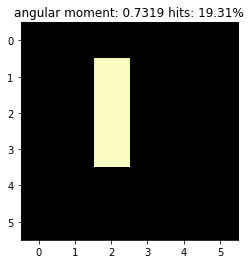

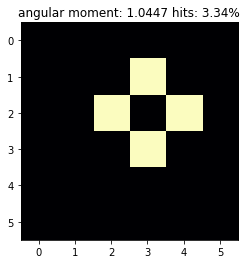

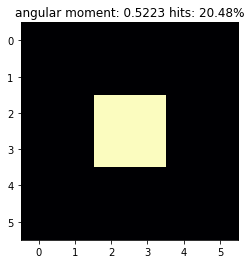

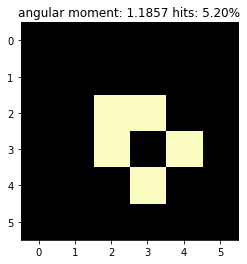

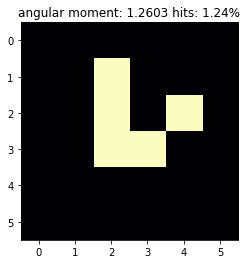

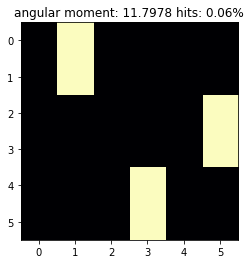

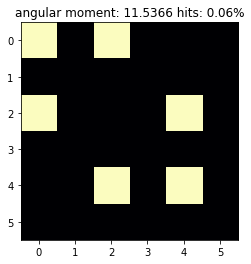

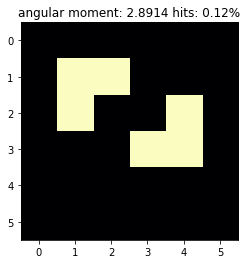

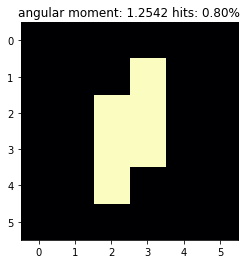

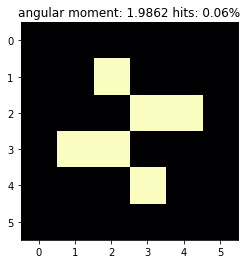

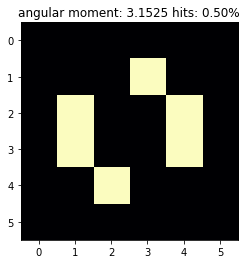

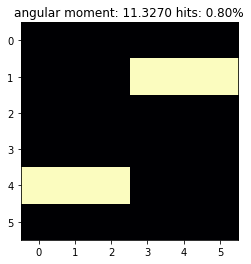

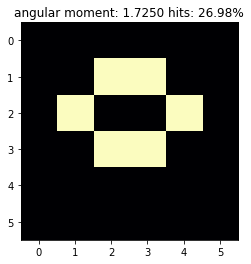

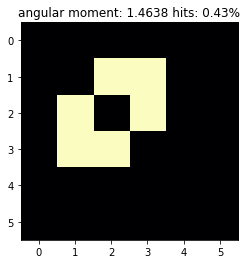

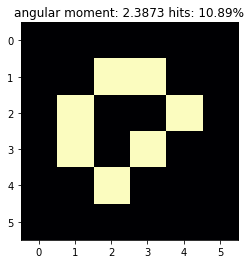

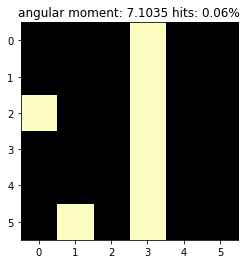

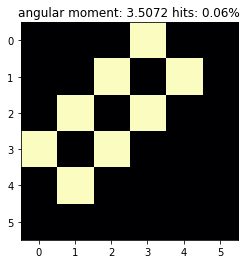

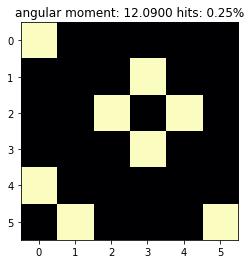

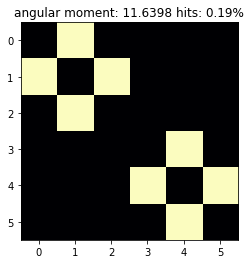

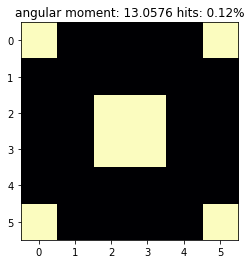

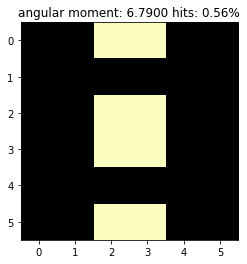

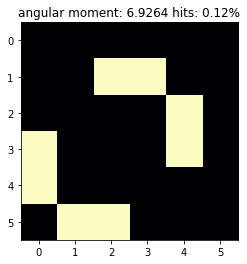

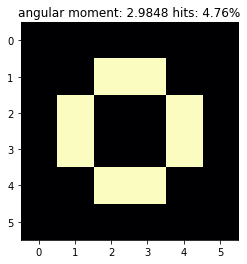

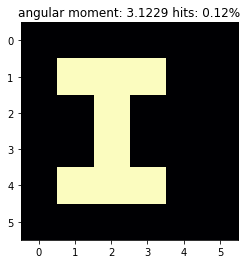

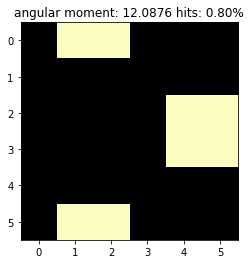

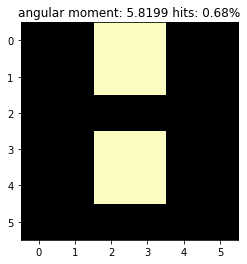

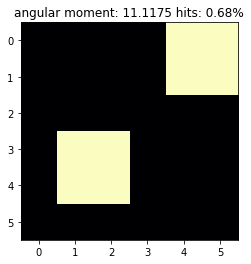

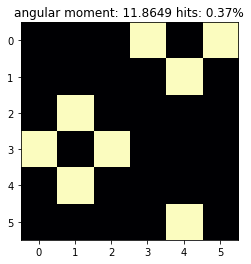

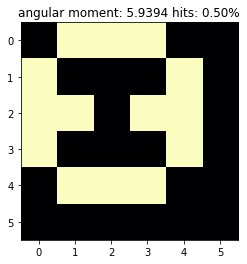

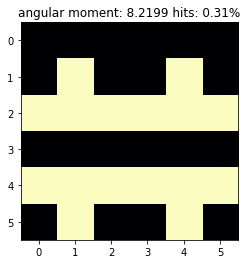

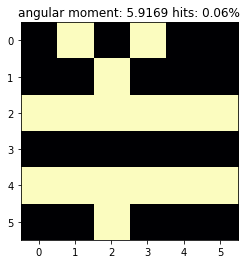

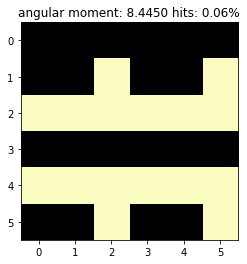

In [8]:
num_cells = np.sum(uniques, axis=(1, 2))
sort_args = np.argsort(num_cells)
uniques = uniques[sort_args]
moments = moments[sort_args]
hits = hits[sort_args]
num_cells = num_cells[sort_args]

for unique, angular_moment, hit in zip(uniques, moments, hits):
    plt.imshow(unique, cmap="magma")
    plt.title(f"angular moment: {angular_moment:.4f} hits: {hit/total_hits:.2%}")
    plt.show()

### Question \#2

Which attractor is most likely to manifest if we initialize the system randomly?

### Answer \#2

The most likely attractor of the system is the zero state, with a hit probability printed below. The second most like attractor by empirical hit probability is plotted below as well.

Ratio of ZERO attractors: 83.84%


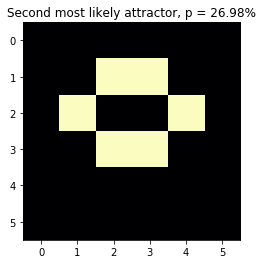

In [9]:
print(f"Ratio of ZERO attractors: {zeros.mean():.2%}")
max_hit = int(np.argmax(hits))
plt.imshow(uniques[max_hit], cmap="magma")
plt.title(f"Second most likely attractor, p = {hits[max_hit] / total_hits:.2%}")
plt.show()

### Question \#3

Is there an initial condition which produces a state after the 100 billionth iteration of the simulation, that is not part of any attractor?

### Answer \#3

Only speaking from the empirical results, the system always reaches in at most about 20 steps a state which is part of an attractor.

### Question \#4

But why the name Cicero?

### Answer \#3

Cuz